Preprocessing

In [1]:
import cv2
import numpy as np
import os
from random import shuffle # mixing data
from tqdm import tqdm

TRAIN_DIR = './TRAIN/'
TEST_DIR = './TEST/'
IMG_SIZE = 50
LR = 1e-3 # Learning rate

MODEL_NAME = 'face_recognition-{}-{}.model'.format(LR, '2conv-basic')

In [2]:
def label_img(img):
    word_label = img.split('.')[-2][:3]
    if word_label == 'kth': return [1, 0, 0, 0, 0]
    elif word_label == 'gih': return [0, 1, 0, 0, 0]
    elif word_label == 'jmh': return [0, 0, 1, 0, 0]
    elif word_label == 'jsp': return [0, 0, 0, 1, 0]
    elif word_label == 'yjs': return [0, 0, 0, 0, 1]    

In [3]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

In [4]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        label = label_img(img)
        path = os.path.join(TEST_DIR,img)
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img),np.array(label)])
        
    shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data

In [5]:
train_data = create_train_data()

100%|███████████████████████████████████████████████████████████████████████████████| 519/519 [00:01<00:00, 471.98it/s]


In [6]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
import tensorflow as tf

tf.reset_default_graph()
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 5, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')



if os.path.exists('C:/Users/dschoi/Desktop/face_recognition/{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

train = train_data

X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]


model.fit({'input': X}, {'targets': Y}, n_epoch=50, snapshot_step=500, batch_size=50, show_metric=True, run_id=MODEL_NAME)

model.save(MODEL_NAME)

Training Step: 549  | total loss: 0.33429 | time: 1.660s
| Adam | epoch: 050 | loss: 0.33429 - acc: 0.8662 -- iter: 500/519
Training Step: 550  | total loss: 0.33502 | time: 1.835s
| Adam | epoch: 050 | loss: 0.33502 - acc: 0.8595 -- iter: 519/519
--
INFO:tensorflow:C:\Users\dschoi\Desktop\face_recognition\face_recognition-0.001-2conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


모델을 학습시킬 경우 dropout방법과, batch를 이용한 학습이 조금 더 좋은 결과를 얻는 경향을 보인다.

In [7]:
test_data = process_test_data()

100%|████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 1614.80it/s]


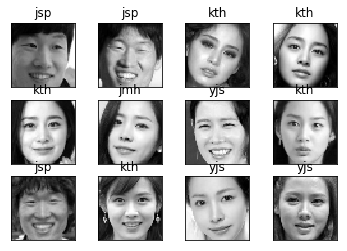

In [8]:
import matplotlib.pyplot as plt

fig=plt.figure()

for num,data in enumerate(test_data[:12]):
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    
    model_out = model.predict([data])[0]
    if np.argmax(model_out) == 0: str_label='kth'
    elif np.argmax(model_out) == 1: str_label='gih'
    elif np.argmax(model_out) == 2: str_label='jmh'
    elif np.argmax(model_out) == 3: str_label='jsp'
    else: str_label='yjs'
    
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

학습 정확도와 테스트 정확도가 비슷한 경향을 보이고, 테스트의 정확도도 비슷하게 보인다. 
조금 더 정확도를 높이려면 데이터셋을 증가시키는 것이 필수이며, 얼굴의 평탄화 작업이 필요할 것 같다.
정면이 아닌 옆모습이 들어올수록 얼굴인식의 정확도가 떨어지는 경향을 보인다.